In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# In recitation 1, we will implement the Bayes filter to iteratively estimate the robot state.

## Algorithm 1: Bayes-filter

Require: Belief  $bel\left(x_{t-1}\right)=p\left(x_{t-1} \mid z_{1: t-1}, u_{1: t-1}\right)$, action $u_t$, measurement $z_t$;

1: for all state variables $x_t$ do

2: $\overline{b e l}\left(x_t\right)=\int p\left(x_t \mid x_{t-1}, u_{t-1}\right) {bel}\left(x_{t-1}\right) \mathrm{d} x_{t-1} \quad / / \quad$ Predict using action/control input $u_t$

3:$bel\left(x_t\right)=\eta p\left(z_t \mid x_t\right) \overline{b e l}\left(x_t\right) \quad / / \quad$ Update using measurement/perceptual data $z_t$

4: return $bel\left(x_t\right)$

In this example, we apply the Bayes filter for 1-D navigation. We consider the robot moving in a 1-D world with 20 grids.

We denote the robot state at time step $k$ and as $x_k$.

The robot can move 1 step forward or stay at the current place, thus we have the motion model $p(x_{k} | x_{k-1}, u_{k-1})$：

if $u_{k-1} = 1$:

$p(x_{k} | x_{k-1}, u_{k-1})=\left\{ \begin{aligned} & 1, \text{if, } x_{k} = x_{k-1} + 1,\\
 & 0, \text{otherwise} \end{aligned} \right. $

if $u_{k-1} = 0$:

$p(x_{k} | x_{k-1}, u_{k-1})=\left\{ \begin{aligned} & 1, \text{if, } x_{k} = x_{k-1},\\
 & 0, \text{otherwise} \end{aligned} \right. $

In [ ]:
# Motion model
# Motion model changes the belief based on action u
def motion_model(xi, xj, u):
    if u == 1:  # move forward
        dx = xi - xj
        if dx == 1 or dx == -19:
            p = 1
        else:
            p = 0
    elif u == 0:  # stay
        dx = xi - xj
        if dx == 0:
            p = 1
        else:
            p = 0
    # print(p)
    # else:
    #     assert (u == 1 or u == 0), 'The action is not defined'
    return p

We also have the measurement at each location: $p(z_k|x_k)$.

We know that the robot receives strong measurements at location $4, 9, 13$, and is noisy.

If the robot receive the measurement, then we have $z_k = 1$ and the measurement map as:

$p(z_k = 1|x_k)=\left\{ \begin{aligned} & 0.8, \text{if, } x_k = 4, 9, or 13,\\
 & 0.05, \text{otherwise.} \end{aligned} \right. $


If the robot does not receive measurement, we have $z_k = 0$.

Then we have
$p(z_k = 0|x_k)=\left\{ \begin{aligned} & 0.2, \text{if, } x_k = 4, 9, or 13,\\
 & 0.95, \text{otherwise.} \end{aligned} \right. $

In [ ]:
# Measurement model
# Measurement model returns p(z|x) based on a likelihood map
def measurement_model(x, likelihood_map, z=1):
  if z == 1:
    return likelihood_map[:, x]
  else:
    return 1 - likelihood_map[:, x]

We also have the initial belief of the robot, i.e. the probability of the robot at location at $x_0$:

$bel(x_0) \in \mathbb{R}_{+}^{20}$

Here we assume we have no information about the robot, thus:

$bel(x_0) = 0.05, x_0 = 1, 2, \dots, 20.$

We also define the action as

$u=[1,1,1,1,1,1,1,0]$.

Then we iteratively apply the propagation and update step to compute the belief.


In [ ]:
#
# Markov localization example in a 1D world
# colors
green = np.array([0.2980, 0.6, 0])
darkblue = np.array([0, 0.2, 0.4])
VermillionRed = np.array([156, 31, 46]) / 255

#
# Action set; 0: stay, 1: move forward
# control inputs (sequence of actions)
u = [1, 1, 1, 1, 1, 1, 1, 0]

# Measurement
z = [1, 0, 0, 0, 0, 1, 0, 0]

# State space: the world has 20 cells, after 20 the robot will be at cell 1 again
X = np.arange(0, 20, 1)

# Belief initialization
bel = np.ones([1, 20]) * 1 / 20  # uniform prior
prior_bel = np.copy(bel)  # use for plot prior belief

# Likelihood map to provide measurements
# The robot receives measurements at cell 4, 9, and 13
likelihood_map = np.ones([1, 20]) * 0.05
for i in [3, 8, 12]:
    likelihood_map[:, i] = 0.8

<ipython-input-11-4b3c7b0f29bf>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(311)


Text(0, 0.5, 'Action')

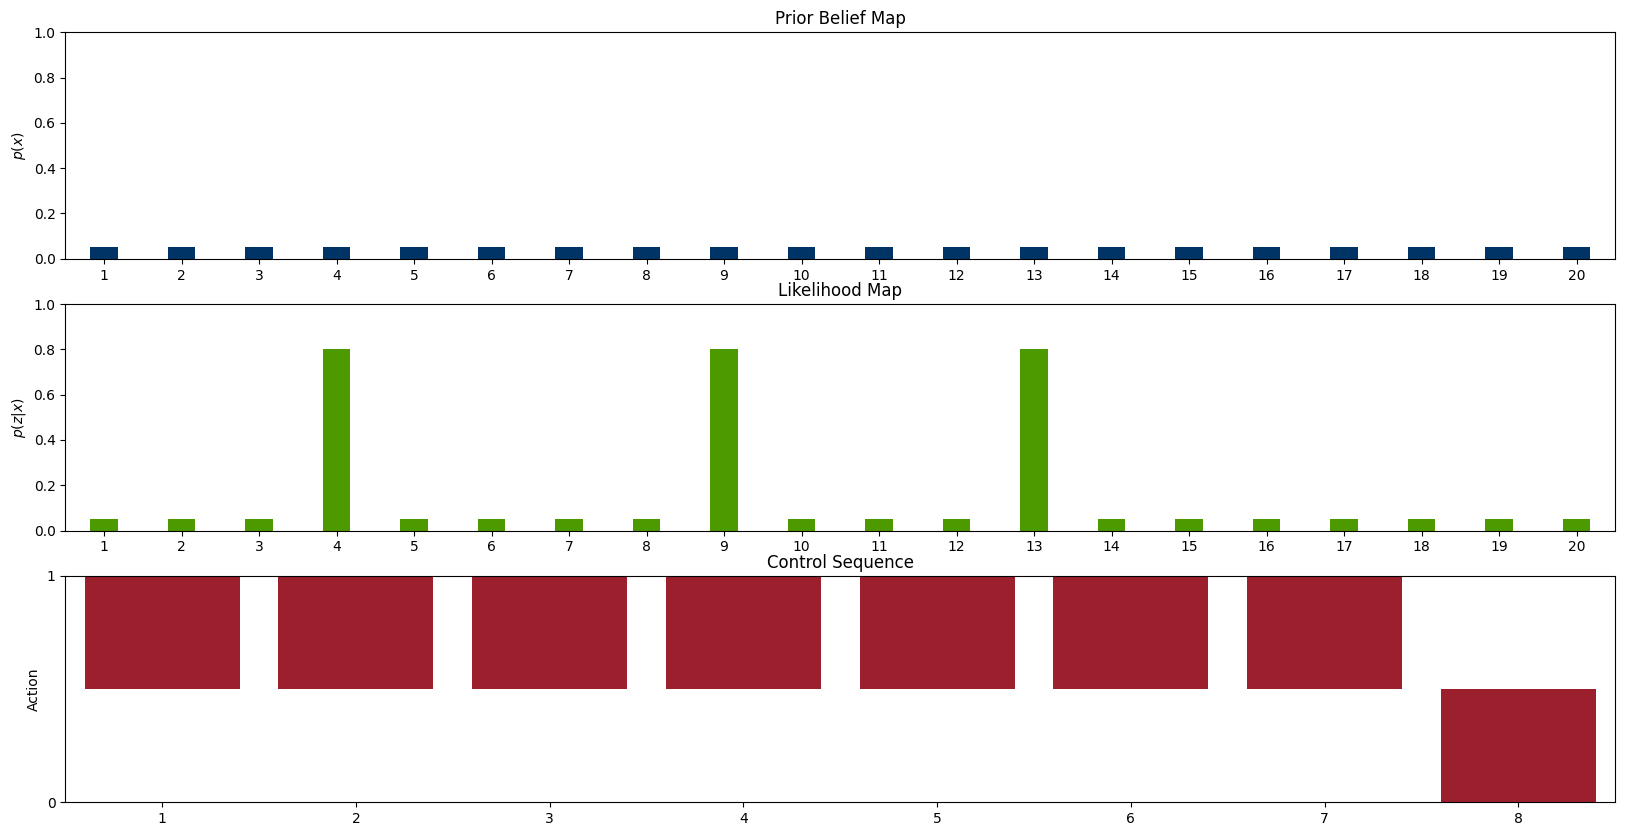

In [ ]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.clf()
plt.grid(True)
width = 0.35  # set bar width

# plot prior
ax1 = plt.subplot(311)
# ax1.set_aspect(3)
plt.bar(X+1, prior_bel.reshape(-1), width, color=darkblue)
plt.title(r'Prior Belief Map')
plt.xticks(X+1)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xlim(0.5, 20.5)
plt.ylim(0, 1)
plt.ylabel(r'$p(x)$')

# plot likelihood
ax2 = plt.subplot(312)
# ax2.set_aspect(3)
plt.bar(X+1, likelihood_map.reshape(-1), width, color=green)
plt.title(r'Likelihood Map')
plt.xticks(X+1)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xlim(0.5, 20.5)
plt.ylim(0, 1)
plt.ylabel(r'$p(z|x)$')

# plot action sequence
ax3 = plt.subplot(313)
# ax3.set_aspect(3)
plt.bar(np.arange(8)+1, np.array(u)-0.5, color=VermillionRed, bottom=0.5)
plt.title(r'Control Sequence')
plt.xlim(0.5, 8.5)
plt.yticks([0, 1])
plt.ylim(0, 1)
plt.ylabel(r'Action')

<ipython-input-12-05c2064776cc>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(311)


<Figure size 640x480 with 0 Axes>

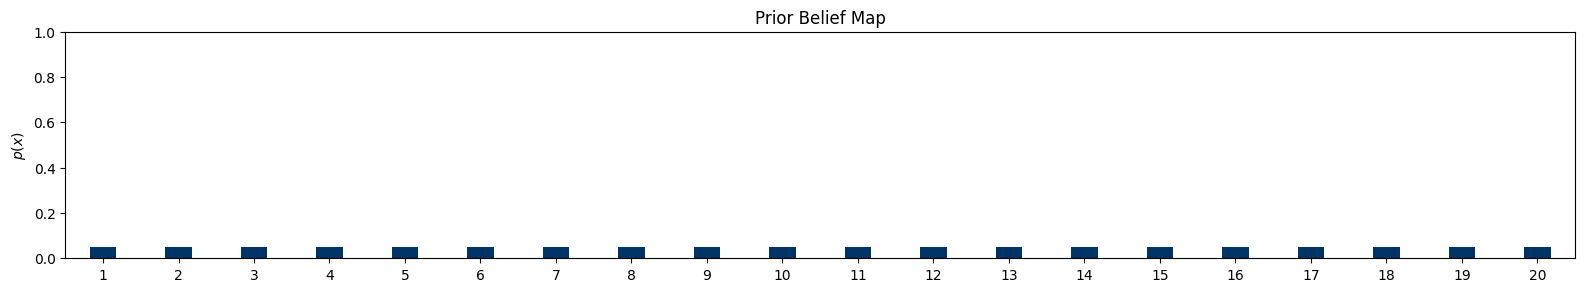

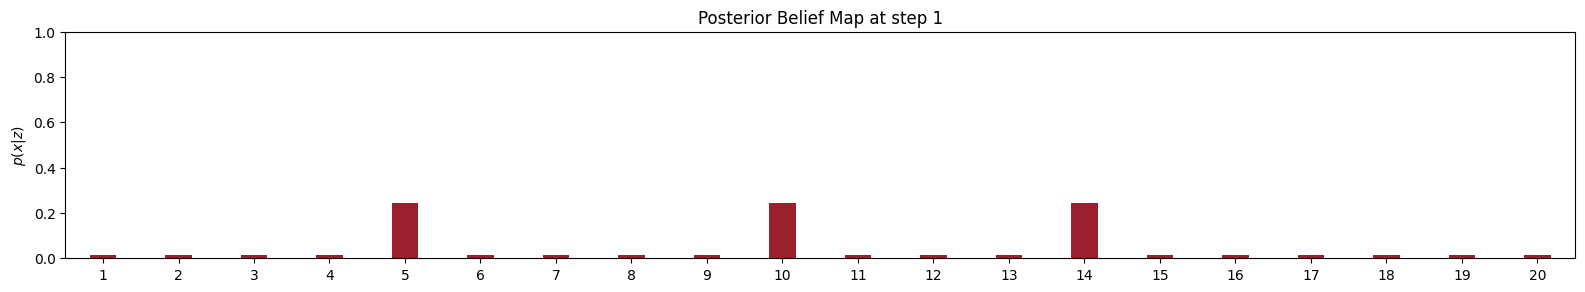

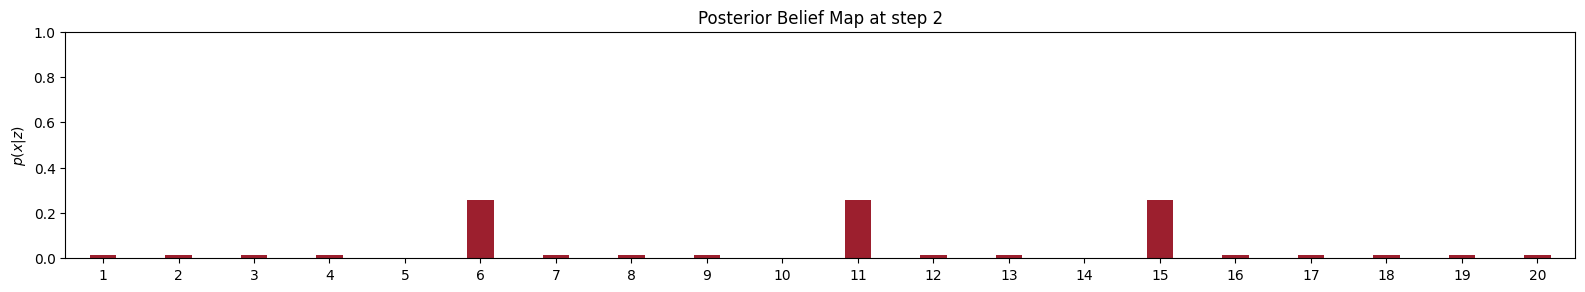

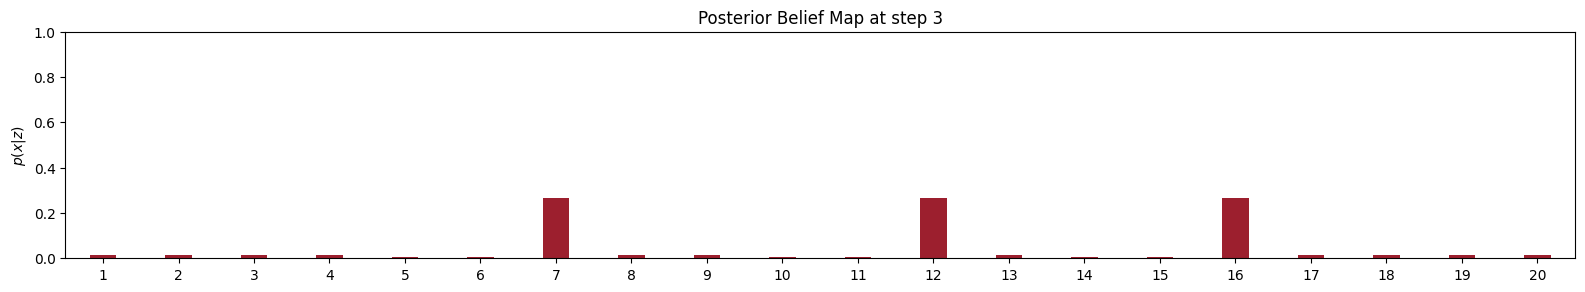

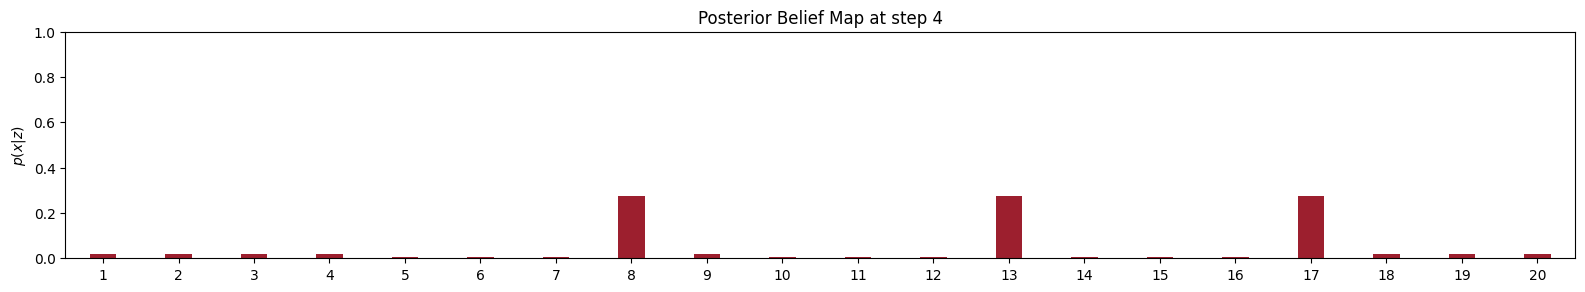

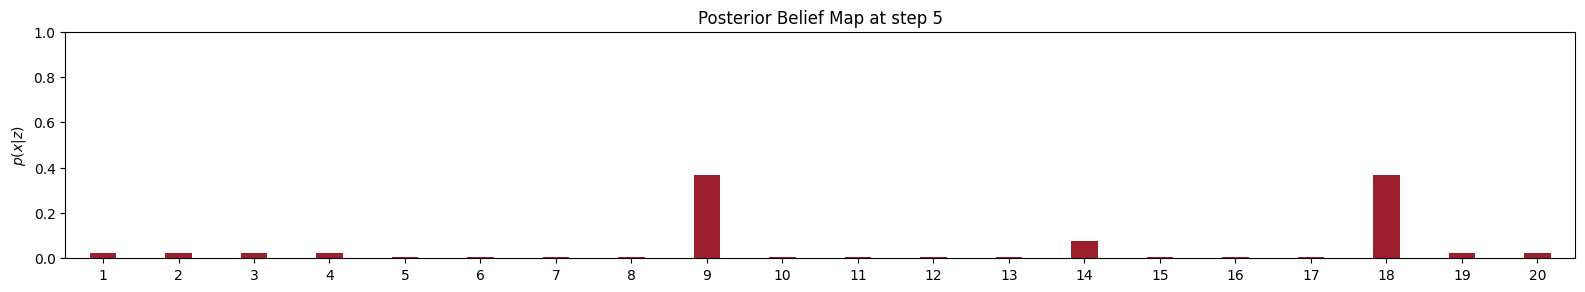

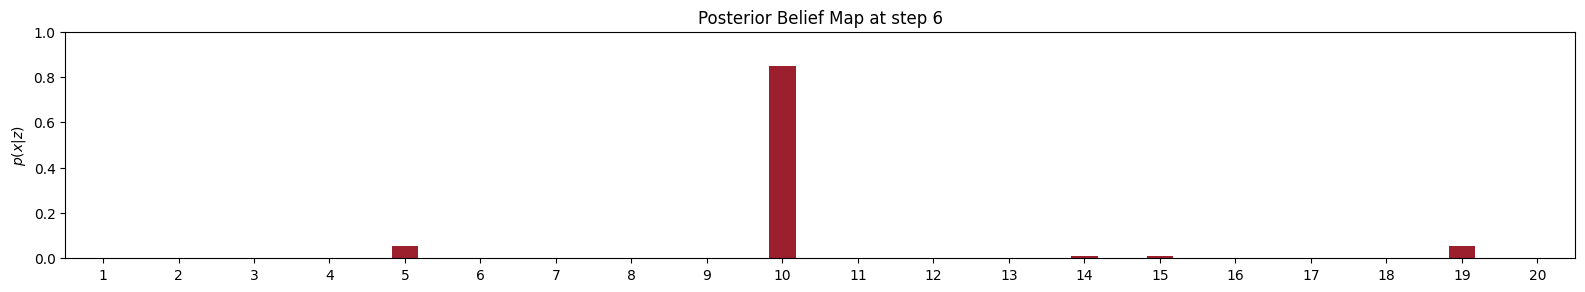

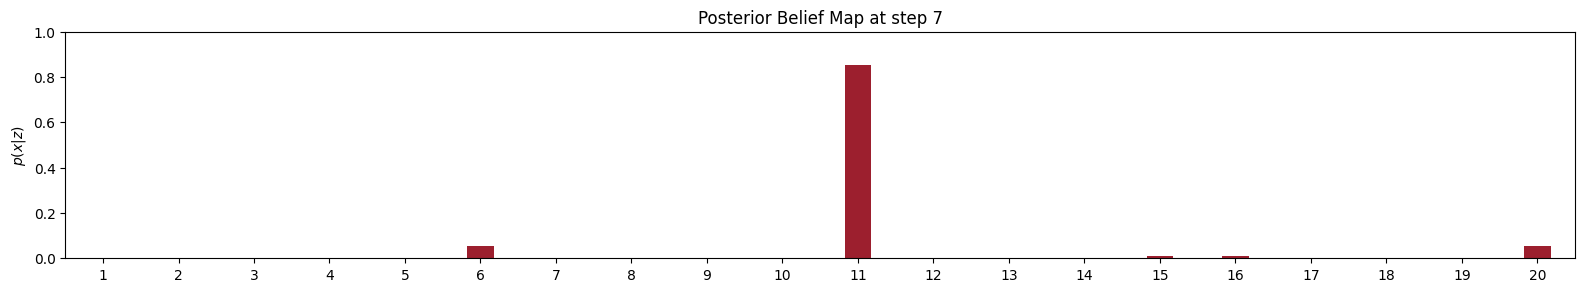

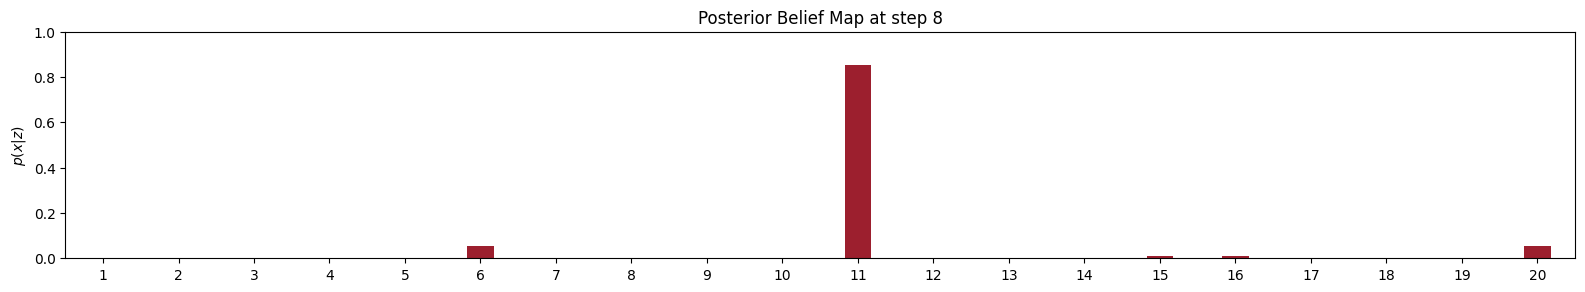

In [ ]:

# Markov Localization using Bayes filter
# This main loop can be run forever, but we run it for a limited sequence of control inputs
k = 0  # step counter
bel_predicted = np.ones([1, 20]) * 1 / 20  # predicted belief
fig = plt.figure()

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)

plt.clf()
plt.grid(True)
width = 0.35  # set bar width

ax1 = plt.subplot(311)
ax1.set_aspect(3)
plt.bar(X+1, prior_bel.reshape(-1), width, color=darkblue)
plt.title(r'Prior Belief Map')
plt.xticks(X+1)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xlim(0.5, 20.5)
plt.ylim(0, 1)
plt.ylabel(r'$p(x)$')

while len(u):
    ############ Update step ############
    if z[k] == 1:  # measurement received
        eta = 0  # normalization constant
        for i in range(len(X)):
            likelihood = measurement_model(X[i], likelihood_map, z=1)  # get measurement likelihood
            bel[:, i] = likelihood * bel_predicted[:, i]  # unnormalized Bayes update
            eta = eta + bel[:, i]
        bel = bel / eta  # normalize belief

    if z[k] == 0:  # No measurement
        eta = 0  # normalization constant
        for i in range(len(X)):
            likelihood = measurement_model(X[i], likelihood_map, z=0)  # get measurement likelihood
            bel[:, i] = likelihood * bel_predicted[:, i]  # unnormalized Bayes update
            eta = eta + bel[:, i]
        bel = bel / eta  # normalize belief

    ############ Prediction step ############
    # prediction; belief convolution
    for m in range(len(X)):
        bel_predicted[:, m] = 0
        for n in range(len(X)):
            pu = motion_model(X[m], X[n], u[0])
            bel_predicted[:, m] = bel_predicted[:, m] + pu * bel[:, n]

    # set the predicted belief as prior
    bel = np.copy(bel_predicted)

    # remove the executed action from the list
    u.remove(u[0])
    k = k + 1

    f = plt.figure()
    f.set_figwidth(40)
    f.set_figheight(10)

    # plot posterior belief
    ax3 = plt.subplot(311)
    ax3.set_aspect(3)
    plt.bar(X+1, bel.reshape(-1), width, color=VermillionRed)
    plt.title(r'Posterior Belief Map at step {0}'.format(8 - len(u)))
    #     plt.title('{0}, {1}, {2}'.format(Name, Test, Date))
    plt.xlim(0.5, 20.5)
    plt.ylim(0, 1)
    plt.ylabel(r'$p(x|z)$')
    plt.xticks(X+1)
    plt.yticks(np.arange(0, 1.2, 0.2))
    if len(u) == 0:
        plt.show()
    else:
        plt.pause(0.5)


